# Part 1 - **Model base**

En aquest notebook compararem el resultat d'aplicar Transfer Learning utilitzant diferents xarxes Resnet (``resnet18``,  ``resnet50``,  ``resnet152``) sense aplicar cap transformació a les imatges, per aconseguir la puntuació base, d'aquesta manera podrem obtenir unes conclusions inicials. Hem escollit aquesta xarxa perquè és la que ja havíem anat treballant a classe, i comparant diferents versions de la mateixa podem anar veient sí a més profunditat de la xarxa, anem veient una millora en l'aprenentatge o no.

<center>

![_Topologia de la xarxa ResNet34. Imatge extreta de Towards Data Science](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Y-u7dH4WC-dXyn9jOG4w0w.png)

_Topologia de la xarxa ResNet34. Imatge extreta de [Towards Data Science](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)._

</center>

### **1. Carregar Imatges**

Comencem important les llibreries que necessitarem durant aquest Notebook. El codi següent està pensat per executar el notebook en un ordinador local:

In [14]:
import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *


from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"


En cas de voler executar-lo des de Google Colab, les llibreries són les següents:

In [15]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

Comprovem que la GPU s'hagi detectat correctament:

In [16]:
#check if cuda is available
torch.cuda.is_available()

True

Ara sí, creem l'objecte ``ImageDataLoader`` per carregar les imatges a la xarxa neuronal:

In [17]:
dls = ImageDataLoaders.from_folder(
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), # Usem CUDA si està disponible
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 512
)

I comprovem que les imatges s'hagin llegit bé:

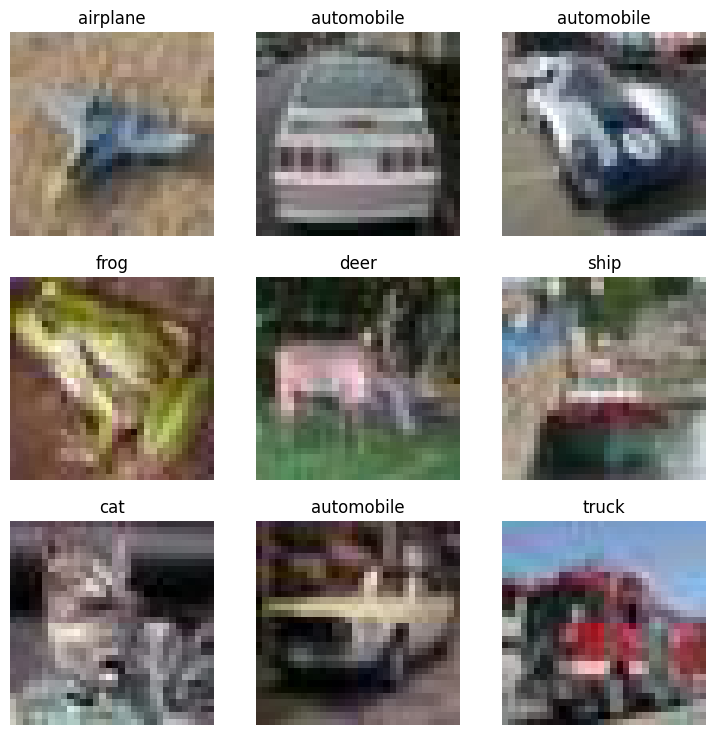

In [18]:
dls.show_batch()

### **2. Resnet18**

Comencem, doncs, entrenant una ``resnet18``. Entrenarem la última capa afegida durant 3 èpoques (``freeze_epochs=3``), i després entrenarem tota la xarxa durant 6 èpoques més.

In [20]:
learn18 = vision_learner(dls, resnet18, metrics=[accuracy, error_rate]).to_fp16()
learn18.fine_tune(6, freeze_epochs=3)

epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.388451,0.500326,0.499674,1.212288,0.573500,0.426500,00:41
1,1.116566,0.616762,0.383238,1.011795,0.649000,0.351000,00:40
2,0.860373,0.716496,0.283504,0.935983,0.683700,0.316300,00:41
3,0.649867,0.791116,0.208884,0.940637,0.695700,0.304300,00:40
4,0.476819,0.849885,0.150115,0.974238,0.696700,0.303300,00:40
5,0.389093,0.875676,0.124324,0.982260,0.696700,0.303300,00:41


A continuació, mostrem gràficament la funció de loss tant en el datset de train com en el de validation:

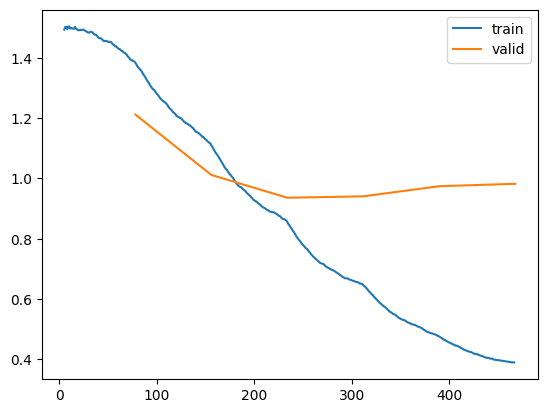

In [21]:
#plot loss and accuracy
learn18.recorder.plot_loss()

Veiem com sembla que estem fent overfitting, ja que a partir dels 200 batchs processats, el model no sembla que estugui aprenent amb el dataset de validation i **a partir del tercer epoch, es queda al 70% d'accuracy**.

Mostrem també la matriu de confusió:

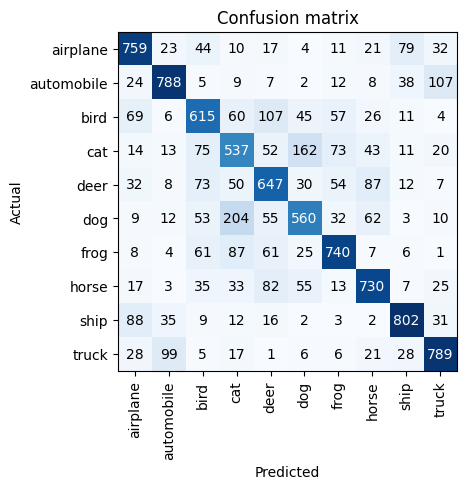

In [22]:
#plot confusion matrix
interp18 = ClassificationInterpretation.from_learner(learn18)
interp18.plot_confusion_matrix()

Sembla que les imatges que el model confón més són les de gats amb les de gossos, juntament amb les de cotxes i camions, i també confón bastant les imatges d'ocells amb cérvols.


I les imatges en què el model s'ha equivocat més:

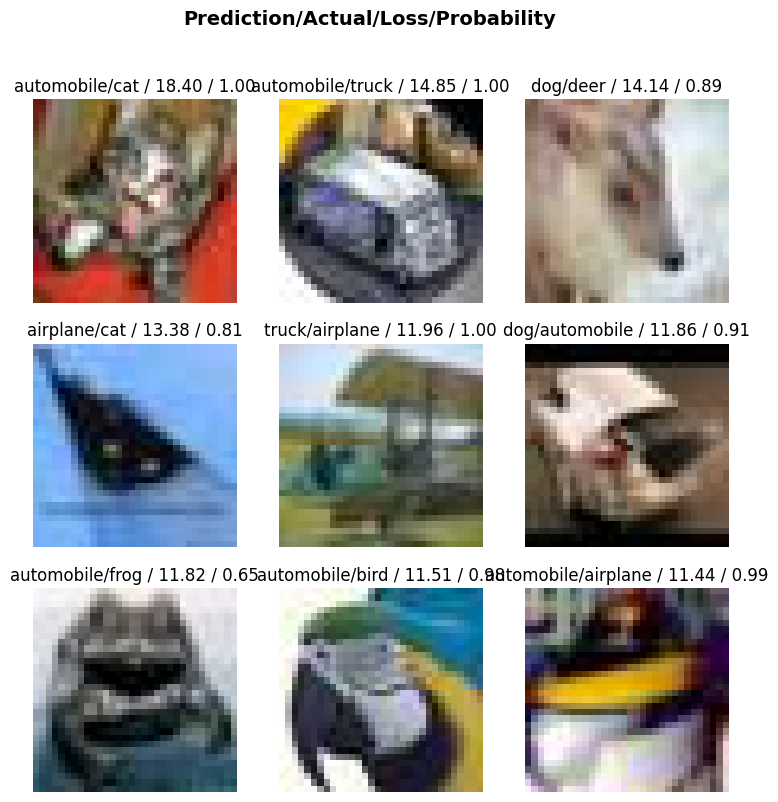

In [23]:
#plot top losses
interp18.plot_top_losses(9, nrows=3)

### **3. Resnet50**

Repetim el procediment fet anteriorment:

In [24]:
learn50 = vision_learner(dls, resnet50, metrics=[accuracy, error_rate]).to_fp16()
learn50.fine_tune(6, freeze_epochs=3)

epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.170111,0.590920,0.409080,1.075245,0.634500,0.365500,00:45
1,0.901840,0.711088,0.288912,0.885292,0.693200,0.306800,00:44
2,0.589852,0.829352,0.170648,0.905732,0.710100,0.289900,00:44
3,0.302329,0.924504,0.075496,1.091173,0.710100,0.289900,00:44
4,0.123847,0.976537,0.023463,1.187959,0.718300,0.281700,00:44
5,0.056280,0.990986,0.009014,1.208734,0.719100,0.280900,00:44


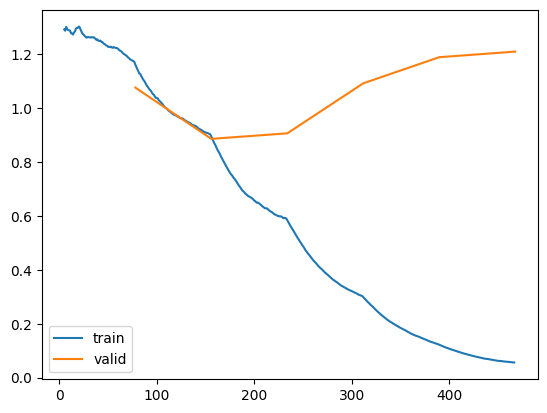

In [25]:
learn50.recorder.plot_loss()

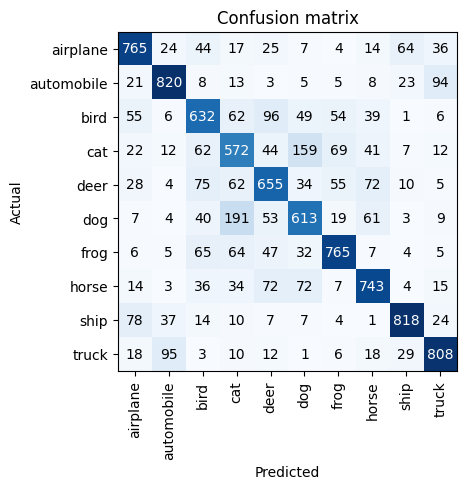

In [26]:
interp50 = ClassificationInterpretation.from_learner(learn50)
interp50.plot_confusion_matrix()

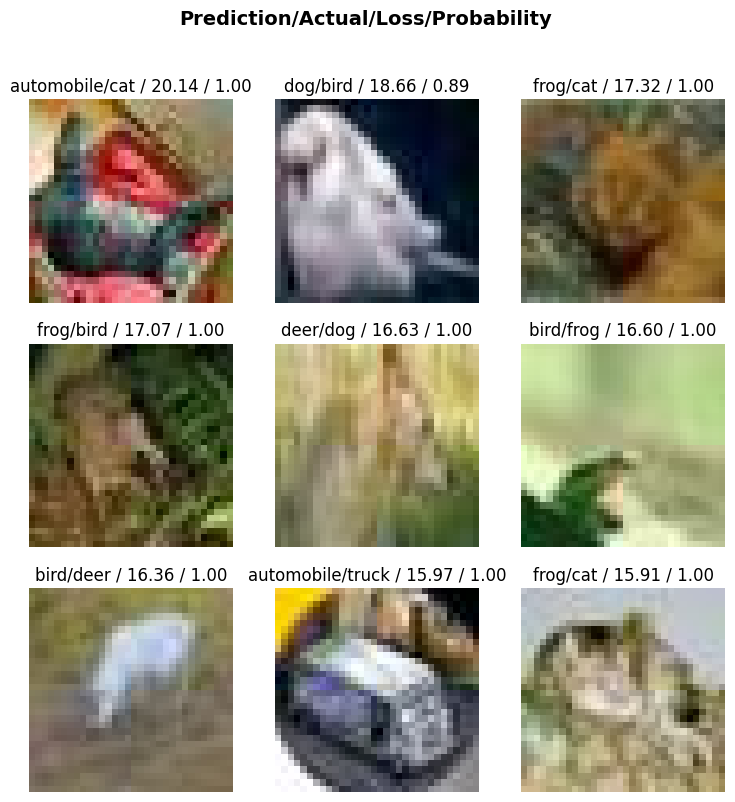

In [27]:
interp50.plot_top_losses(9, nrows=3)

Veiem que aquí les conclusions són bastant similars: tot i que **l'accuracy en el dataset de validació ha pujat fins al 72%, estem cometent encara més overfitting que abans**. Sembla però, que aquest cop ja no confón tant com abans elements com automòbils i camions. També cal dir que el temps per cada epoch ha augmentat en uns 5 segons.

### **4. Resnet152**

Novament, repetim els passos anteriors:

In [28]:
learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate]).to_fp16()
learn152.fine_tune(6, freeze_epochs=3)

epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,1.104210,0.610677,0.389323,1.059336,0.659600,0.340400,00:49
1,0.802610,0.752754,0.247246,0.947732,0.711100,0.288900,00:52
2,0.510101,0.854192,0.145808,0.892697,0.726800,0.273200,00:50
3,0.226633,0.949294,0.050706,1.008804,0.734400,0.265600,00:50
4,0.078693,0.990159,0.009841,1.080010,0.738400,0.261600,00:49
5,0.030380,0.996645,0.003355,1.092979,0.739200,0.260800,00:49


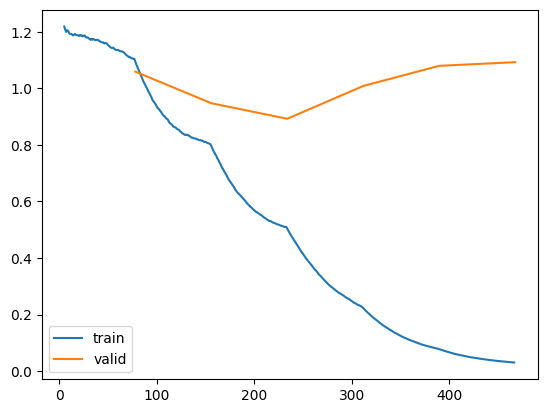

In [29]:
learn152.recorder.plot_loss()

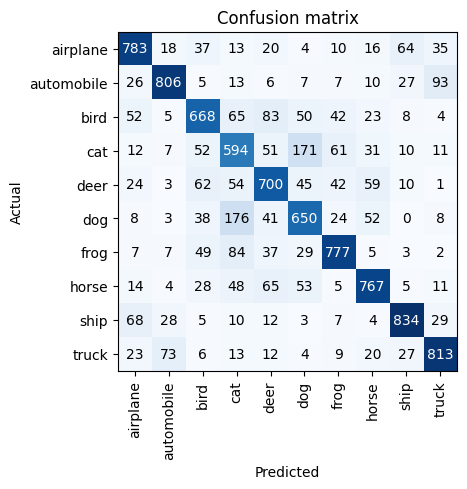

In [30]:
inter152 = ClassificationInterpretation.from_learner(learn152)
inter152.plot_confusion_matrix()

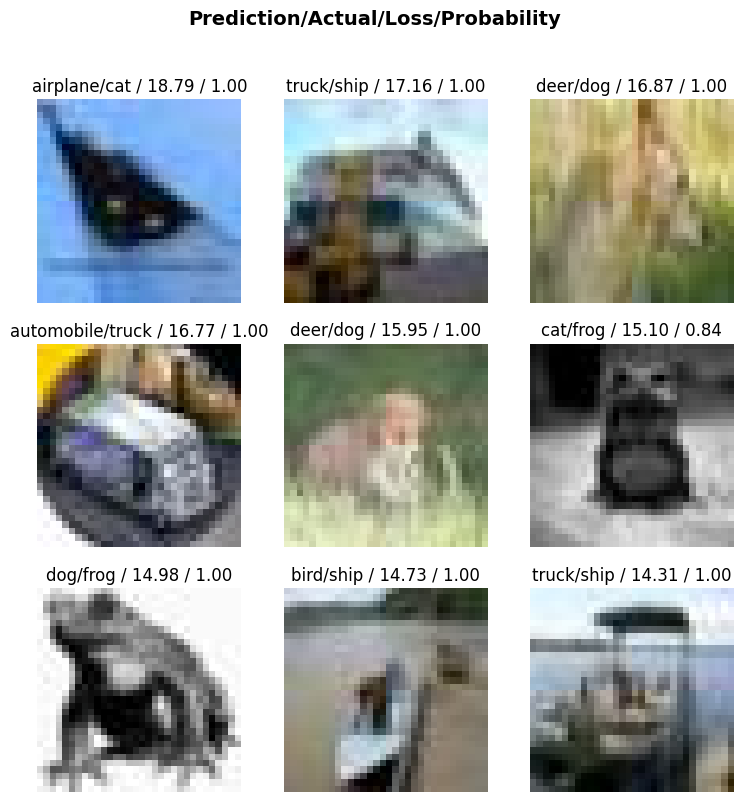

In [31]:
inter152.plot_top_losses(9, nrows=3)

En aquest cas podem veure com els resultats d'utilitzar una ``resnet152`` són molts semblants als de fer servir la ``resnet50``, sembla que disminueix molt lleugerament l'overfitting, l'accuracy és superior (ja pugem fins al 74%), pero el temps per epoch també incrementa, ja que ja estem en l'ordre de 50 segons per epoch.
